In [1]:
# Standard library imports
import os
import math

# Third-party package imports for data manipulation
import pandas as pd
import numpy as np

# PyTorch imports for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Visualization and logging tools
from tqdm import tqdm
import matplotlib.pyplot as plt
import wandb  # Weights & Biases for experiment tracking

# Custom modules
from autoencoder import Autoencoder  # Assuming this is your custom autoencoder class

# Configure environment variables for Weights & Biases
os.environ["WANDB_SILENT"] = "true"

# Initialize Weights & Biases
wandb.login()
wandb.init(project="PLR", tags=["Leo"], group="Autoencoders")

# Set the device for PyTorch (CPU in this case)
device = torch.device("cpu")


In [3]:
# Load the data
data = pd.read_csv('data/skew_corr_group.csv')
data.fillna(0, inplace=True)

# Convert DataFrame to numpy array and then to PyTorch tensor
tensor = torch.tensor(data.values, dtype=torch.float32)
dataset = TensorDataset(tensor, tensor)  # Autoencoder takes the same input and output

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


The Binary Cross-Entropy loss for each data point \( x \) is given by:

$$
\text{BCE}(y, \hat{y}) = - (y \log(\hat{y}) + (1-y) \log(1-\hat{y}))
$$


In [4]:
def train_autoencoder(model, train_loader, val_loader, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(epochs), desc=f'Latent Dim {model.latent_dim}'):
        model.train()
        total_train_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
    
    return train_losses, val_losses


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Latent Dim 2: 100%|██████████| 50/50 [00:05<00:00,  8.40it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
Latent Dim 5: 100%|██████████| 50/50 [00:05<00:00,  8.41it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
Latent Dim 10: 100%|██████████| 50/50 [00:06<00:00,  8.32it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Latent Dim 20: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Latent Dim 30: 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
Latent Dim 40: 100%|██████████| 50/50 [00:06<00:00,  7.76it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Latent Dim 50: 100%|██████████| 50/50 [00:06<00:00,  7.37it/s]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


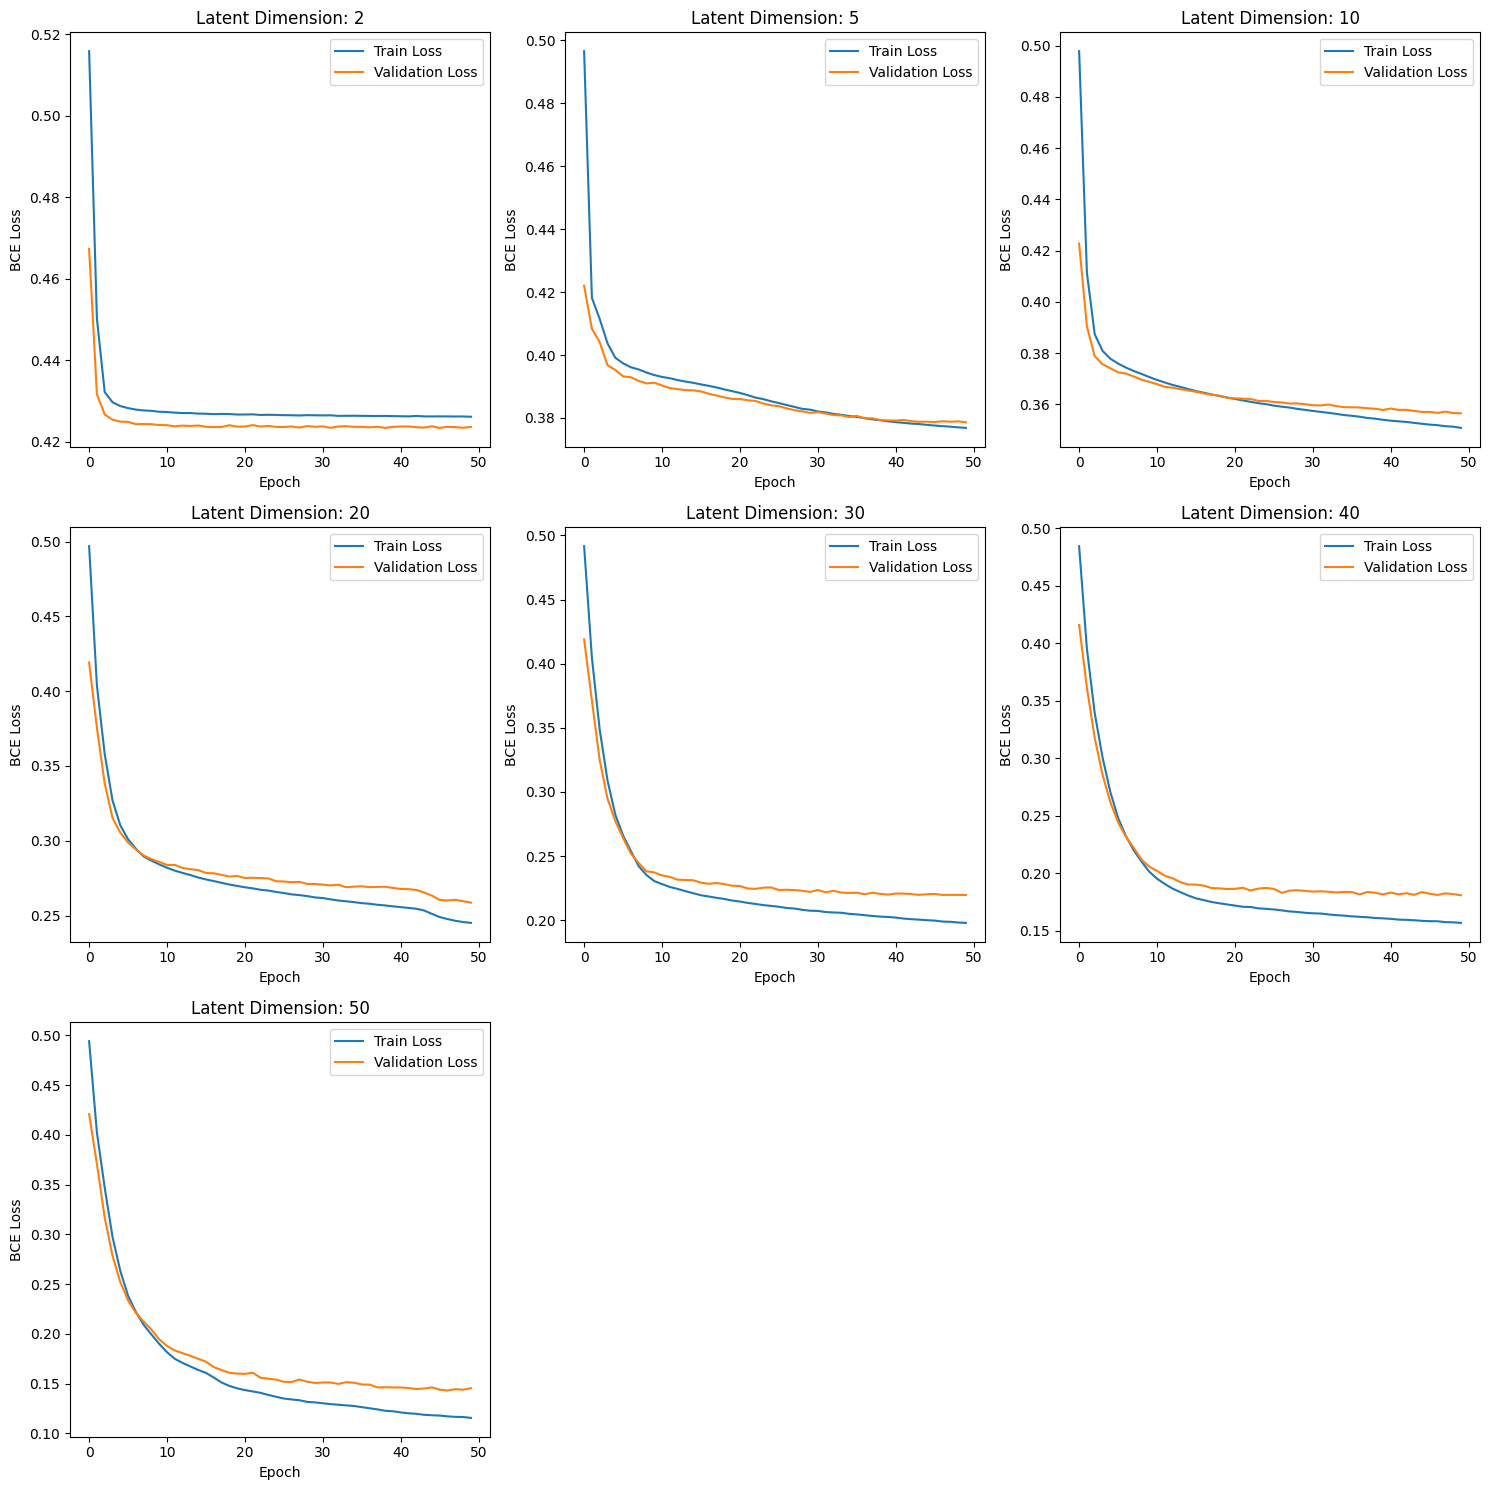

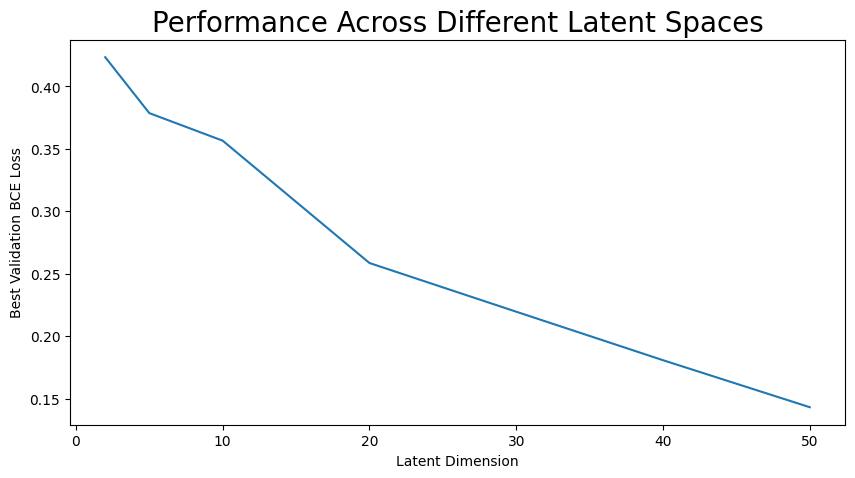

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [5]:
latent_dims = [2, 5, 10, 20, 30, 40, 50]
final_val_losses = []

# Calculate rows and columns for subplots
n = len(latent_dims)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten axs to handle both cases when it's an array of subplots or a single subplot
axs = axs.flatten()

for idx, dim in enumerate(latent_dims):
    
    # Start a new run for each latent dimension
    with wandb.init(project="PLR", tags=["Leo"], group="Autoencoders", name=f"latent_dim={dim}") as run:
        wandb.config.latent_dim = dim  # Log the latent dimension as a hyperparameter

        # Create and train the autoencoder
        model = Autoencoder(input_dim=data.shape[1], latent_dim=dim)
        train_losses, val_losses = train_autoencoder(model, train_loader, val_loader)

        # Add back the missing plotting code
        axs[idx].plot(train_losses, label='Train Loss')
        axs[idx].plot(val_losses, label='Validation Loss')
        axs[idx].set_title(f"Latent Dimension: {dim}")
        axs[idx].set_xlabel('Epoch')
        axs[idx].set_ylabel('BCE Loss')
        axs[idx].legend()
        
        # Log losses to wandb
        for epoch, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
            wandb.log({"Train Loss": train_loss, "Validation Loss": val_loss, "epoch": epoch})

        # Store final validation loss for the current latent dimension
        final_val_loss = min(val_losses)
        final_val_losses.append(final_val_loss)

        # Log final validation loss to wandb
        wandb.log({"Best Validation Loss": final_val_loss})

# Hide any unused subplots
for idx in range(len(latent_dims), rows * cols):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

# Plot overall performance
plt.figure(figsize=(10, 5))
plt.plot(latent_dims, final_val_losses)
plt.xlabel('Latent Dimension')
plt.ylabel('Best Validation BCE Loss')
plt.title('Performance Across Different Latent Spaces', fontsize=20)
plt.show()

# Log final validation losses for all latent dimensions to the main run
wandb.init(project="PLR", tags=["Leo"], group="Autoencoders", name="Summary")
wandb.log({"Best Validation Losses": final_val_losses, "Latent Dimensions": latent_dims})

# Your code for plotting the summary figure here
wandb.finish()
